In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18, resnet50
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

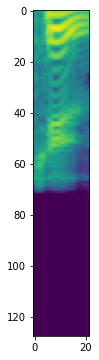

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 4):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def TimeCycleShift(image, max_shift = 4):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def TimeSwapAugmentation(image, max_b = 4):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def TimeRandomSwap(image, max_b = 4):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(4)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(25)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 25, 4)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)   
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
class AudioMNIST(Dataset):
    def __init__(self, keys, data = [], labels = []):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [15]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, use_augmentation = False, aug_type = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    
    for epoch in tqdm(range(epochs)):
        #Train
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            if use_augmentation:
                for i in range(len(y)):
                    if np.random.rand() < 0.5:
                        X[i] = augmentation(X[i], mode = aug_type)
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        
        #Validation
        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, [train_losses, valid_losses, valid_acc]

In [16]:
def evaluate(model, test_loader):
    model.eval()
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)

    mean_accuracy = sum_accuracy / cnt_objects
    print('************************')
    print('Quality of the model')
    print('Accuracy on test:', mean_accuracy)
    return mean_accuracy

In [17]:
no_augmentation_accuracy18 = []
time_random_swap_accuracy18 = []
time_swap_augmentation_accuracy18 = []

no_augmentation_accuracy50 = []
time_random_swap_accuracy50 = []
time_swap_augmentation_accuracy50 = []

# Random seed = 1

In [18]:
random_seed = 1

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9690189328743546


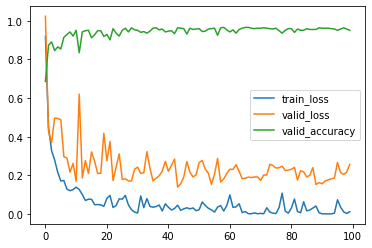

In [19]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 1


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Accuracy on the validation:  0.967741935483871
************************
Quality of the model
Accuracy on test: 0.9604130808950087


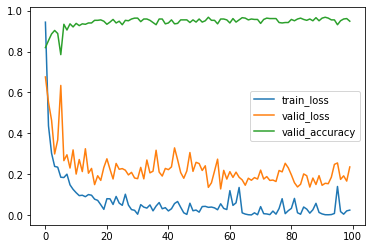

In [20]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 1


100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


Accuracy on the validation:  0.9720430107526882
************************
Quality of the model
Accuracy on test: 0.9621342512908778


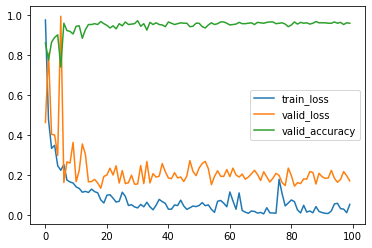

In [21]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [06:11<00:00,  3.71s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.9483648881239243


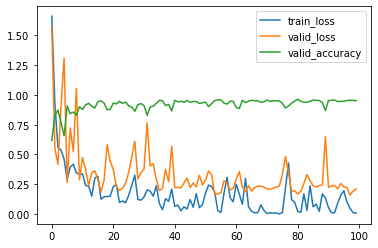

In [22]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 1


100%|██████████| 100/100 [06:17<00:00,  3.78s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9500860585197934


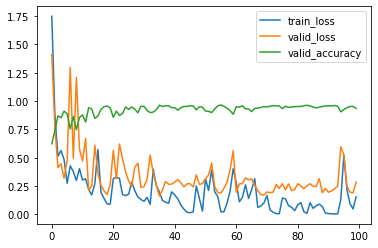

In [23]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 1


100%|██████████| 100/100 [06:19<00:00,  3.80s/it]


Accuracy on the validation:  0.967741935483871
************************
Quality of the model
Accuracy on test: 0.9586919104991394


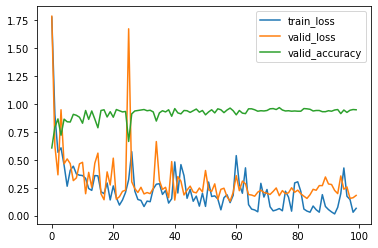

In [24]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 42

In [25]:
random_seed = 42

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.955249569707401


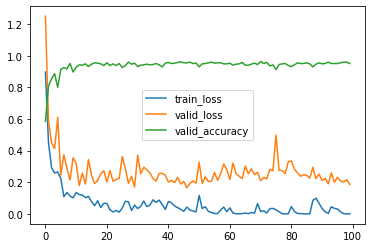

In [26]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 42


100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


Accuracy on the validation:  0.967741935483871
************************
Quality of the model
Accuracy on test: 0.9672977624784854


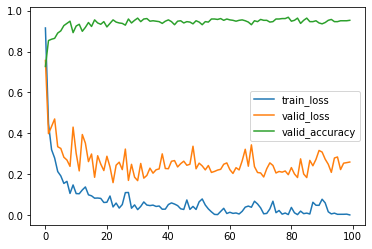

In [27]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 42


100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


Accuracy on the validation:  0.967741935483871
************************
Quality of the model
Accuracy on test: 0.9604130808950087


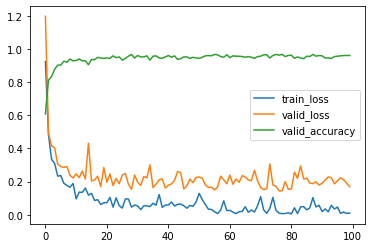

In [28]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [06:12<00:00,  3.72s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.9397590361445783


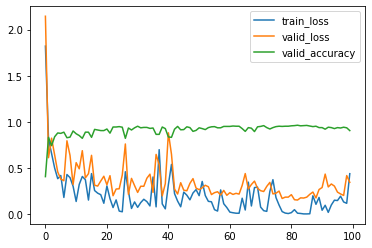

In [29]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 42


100%|██████████| 100/100 [06:17<00:00,  3.78s/it]


Accuracy on the validation:  0.956989247311828
************************
Quality of the model
Accuracy on test: 0.9414802065404475


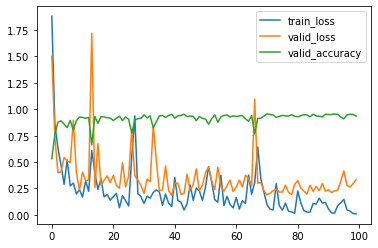

In [30]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 42


100%|██████████| 100/100 [06:20<00:00,  3.80s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.9707401032702238


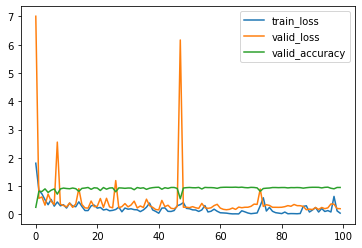

In [31]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 10

In [32]:
random_seed = 10

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.9500860585197934


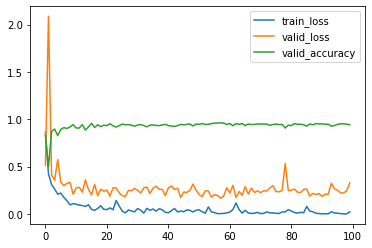

In [33]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 10


100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


Accuracy on the validation:  0.9612903225806452
************************
Quality of the model
Accuracy on test: 0.955249569707401


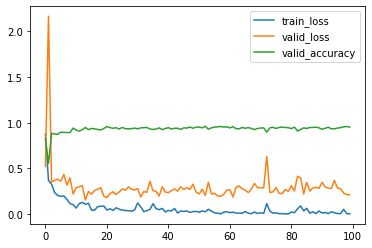

In [34]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 10


100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9586919104991394


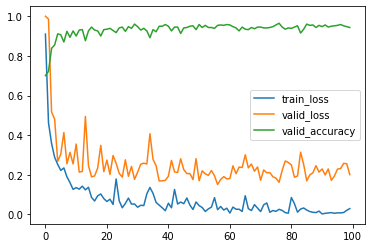

In [35]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [06:12<00:00,  3.72s/it]


Accuracy on the validation:  0.9505376344086022
************************
Quality of the model
Accuracy on test: 0.9483648881239243


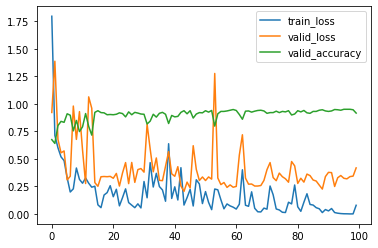

In [36]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 10


100%|██████████| 100/100 [06:20<00:00,  3.81s/it]


Accuracy on the validation:  0.946236559139785
************************
Quality of the model
Accuracy on test: 0.9483648881239243


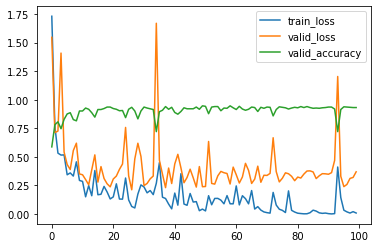

In [37]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 10


100%|██████████| 100/100 [06:20<00:00,  3.81s/it]


Accuracy on the validation:  0.9505376344086022
************************
Quality of the model
Accuracy on test: 0.9449225473321858


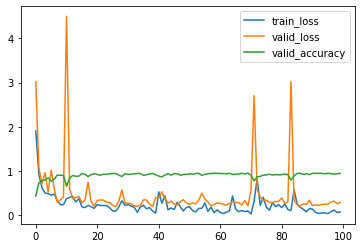

In [38]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 15

In [39]:
random_seed = 15

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


Accuracy on the validation:  0.967741935483871
************************
Quality of the model
Accuracy on test: 0.9621342512908778


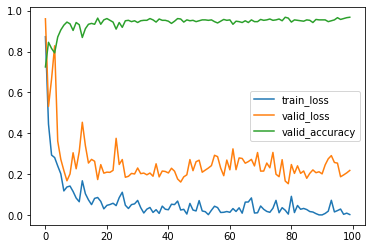

In [40]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

  0%|          | 0/100 [00:00<?, ?it/s]

setting everything to seed 15


100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


Accuracy on the validation:  0.9741935483870968
************************
Quality of the model
Accuracy on test: 0.9569707401032702


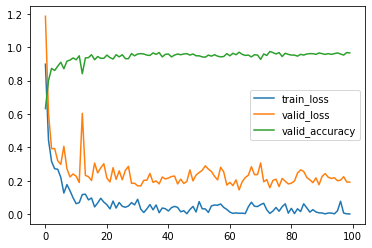

In [41]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

  0%|          | 0/100 [00:00<?, ?it/s]

setting everything to seed 15


100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


Accuracy on the validation:  0.9698924731182795
************************
Quality of the model
Accuracy on test: 0.9518072289156626


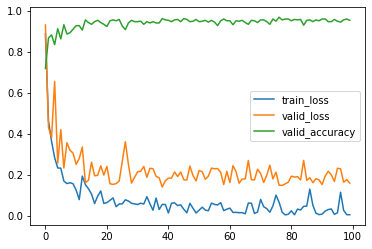

In [42]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [06:14<00:00,  3.75s/it]


Accuracy on the validation:  0.956989247311828
************************
Quality of the model
Accuracy on test: 0.9483648881239243


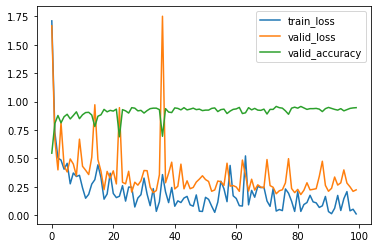

In [43]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 15


100%|██████████| 100/100 [06:20<00:00,  3.81s/it]


Accuracy on the validation:  0.9548387096774194
************************
Quality of the model
Accuracy on test: 0.9466437177280551


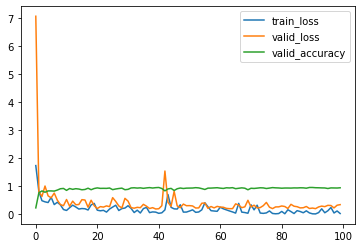

In [44]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 15


100%|██████████| 100/100 [06:21<00:00,  3.81s/it]


Accuracy on the validation:  0.967741935483871
************************
Quality of the model
Accuracy on test: 0.9569707401032702


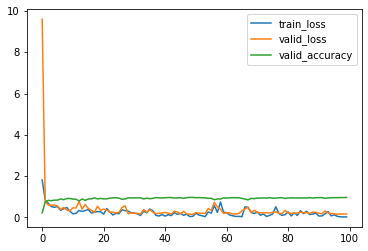

In [45]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 23

In [46]:
random_seed = 23

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = AudioMNIST(data = data, labels = labels, keys = train_keys)
valid_dataset = AudioMNIST(data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


Accuracy on the validation:  0.9698924731182795
************************
Quality of the model
Accuracy on test: 0.9466437177280551


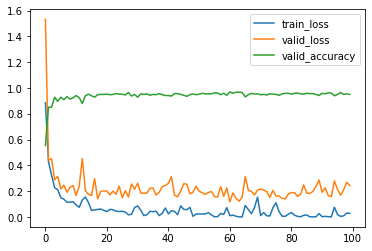

In [47]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

  0%|          | 0/100 [00:00<?, ?it/s]

setting everything to seed 23


100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


Accuracy on the validation:  0.9698924731182795
************************
Quality of the model
Accuracy on test: 0.9414802065404475


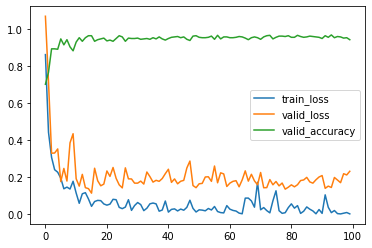

In [48]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 23


100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Accuracy on the validation:  0.9698924731182795
************************
Quality of the model
Accuracy on test: 0.9380378657487092


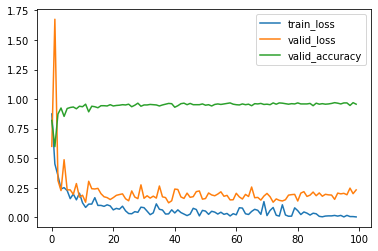

In [49]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [06:12<00:00,  3.73s/it]


Accuracy on the validation:  0.9655913978494624
************************
Quality of the model
Accuracy on test: 0.9397590361445783


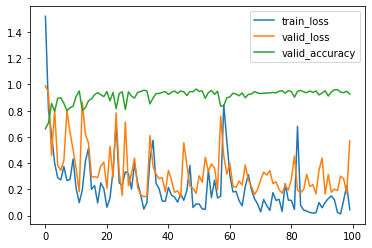

In [50]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 23


100%|██████████| 100/100 [06:20<00:00,  3.80s/it]


Accuracy on the validation:  0.9698924731182795
************************
Quality of the model
Accuracy on test: 0.9397590361445783


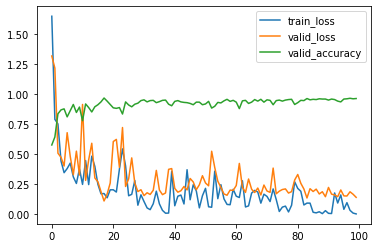

In [51]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 23


100%|██████████| 100/100 [06:21<00:00,  3.82s/it]


Accuracy on the validation:  0.9634408602150538
************************
Quality of the model
Accuracy on test: 0.9414802065404475


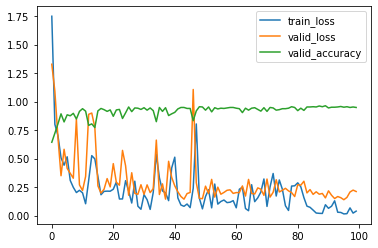

In [52]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Results

In [53]:
print("resnet18")
no_augmentation_accuracy18 = np.array(no_augmentation_accuracy18) * 100
time_random_swap_accuracy18 = np.array(time_random_swap_accuracy18) * 100
time_swap_augmentation_accuracy18 = np.array(time_swap_augmentation_accuracy18) * 100
print("No augmentation")
print("mean:", np.mean(no_augmentation_accuracy18))
print("std:", np.std(no_augmentation_accuracy18))
print("TimeSwapAugmentation")
print("mean:", np.mean(time_swap_augmentation_accuracy18))
print("std:", np.std(time_swap_augmentation_accuracy18))
print("TimeRandomSwap")
print("mean:", np.mean(time_random_swap_accuracy18))
print("std:", np.std(time_random_swap_accuracy18))

resnet18
No augmentation
mean: 95.66265060240964
std: 0.8102307949011932
TimeSwapAugmentation
mean: 95.62822719449225
std: 0.8474033476826971
TimeRandomSwap
mean: 95.42168674698794
std: 0.8816694302833524


In [54]:
print("resnet50")
no_augmentation_accuracy50 = np.array(no_augmentation_accuracy50) * 100
time_random_swap_accuracy50 = np.array(time_random_swap_accuracy50) * 100
time_swap_augmentation_accuracy50 = np.array(time_swap_augmentation_accuracy50) * 100
print("No augmentation")
print("mean:", np.mean(no_augmentation_accuracy50))
print("std:", np.std(no_augmentation_accuracy50))
print("TimeSwapAugmentation")
print("mean:", np.mean(time_swap_augmentation_accuracy50))
print("std:", np.std(time_swap_augmentation_accuracy50))
print("TimeRandomSwap")
print("mean:", np.mean(time_random_swap_accuracy50))
print("std:", np.std(time_random_swap_accuracy50))

resnet50
No augmentation
mean: 94.49225473321859
std: 0.4215989230263653
TimeSwapAugmentation
mean: 94.52667814113597
std: 0.3984797556898501
TimeRandomSwap
mean: 95.45611015490533
std: 1.0475128436972754
